In [106]:
import numpy as np
import pandas as pd
import re
import time
import math
import random
from tqdm import tqdm
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from keras import backend as K 
import gensim
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from sklearn.model_selection import train_test_split
import unicodedata
import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

Reading Dataset from kaggle : https://www.kaggle.com/sunnysai12345/news-summary

After reading the dataset we store it into DataFrame from pandas library

In [6]:
summary_df = pd.read_csv('news_summary.csv', error_bad_lines=False,engine='python', usecols=['headlines', 'text'])
raw_df = pd.read_csv('/content/news_summary_more.csv', error_bad_lines=False,engine='python', usecols=['headlines', 'text'])

In [7]:
df = pd.concat([summary_df, raw_df], axis=0).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


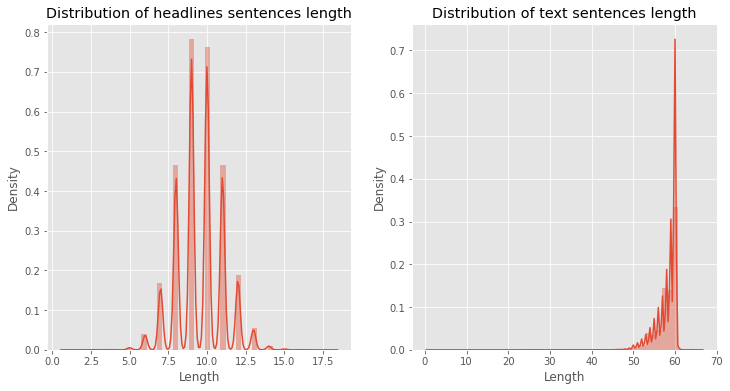

In [8]:
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')
plt.subplot(1, 2, 1)
sns.distplot(df['headlines'].str.split().apply(len))
plt.title('Distribution of headlines sentences length')
plt.xlabel('Length')

plt.style.use('ggplot')
plt.subplot(1, 2, 2)
sns.distplot(df['text'].str.split().apply(len))
plt.title('Distribution of text sentences length')
plt.xlabel('Length')
plt.show()

In [9]:
df['headlines'].head

,headlines,text
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...
...,...,...
102910,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
102911,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
102912,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
102913,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


# Data Cleaning

Pada Data Cleaning ini kelompok kami akan menggunakan metode Regular Expressions dari library 're', dengan menggunakan dasar dari string manipulation. Dimana pada manipulasi string ini akan membantu membuat data yang dikerjakan lebih konsisten karena setiap dataset yang kita dapat terdiri dari text yang tidak tersturktur atau unstructured-text.

In [11]:
def cleansing(column):
  for row in column:
    row=re.sub("(\\t)", ' ', str(row)).lower()
    row=re.sub("(\\r)", ' ', str(row)).lower() 
    row=re.sub("(\\n)", ' ', str(row)).lower()
    
    row=re.sub("(__+)", ' ', str(row)).lower()  
    row=re.sub("(--+)", ' ', str(row)).lower()  
    row=re.sub("(~~+)", ' ', str(row)).lower()  
    row=re.sub("(\+\++)", ' ', str(row)).lower()  
    row=re.sub("(\.\.+)", ' ', str(row)).lower()  
    
    row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower()
    
    row=re.sub("(mailto:)", ' ', str(row)).lower()
    row=re.sub(r"(\\x9\d)", ' ', str(row)).lower()
    row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower()
    row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower()
    
    
    row=re.sub("(\.\s+)", ' ', str(row)).lower()
    row=re.sub("(\-\s+)", ' ', str(row)).lower()
    row=re.sub("(\:\s+)", ' ', str(row)).lower()
    row=re.sub("(\s+.\s+)", ' ', str(row)).lower()
    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
        repl_url = url.group(3)
        row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
    except:
        pass
    

    
    row = re.sub("(\s+)",' ',str(row)).lower()
    
  
    row=re.sub("(\s+.\s+)", ' ', str(row)).lower()

    
    
    yield row

In [14]:
cleans_df1 = cleansing(df['text'])
cleans_df2 = cleansing(df['headlines'])

In [16]:
nlp = spacy.load('en', disable=['ner', 'parser'])

text = [str(doc) for doc in nlp.pipe(cleans_df1, batch_size=5000, n_threads=-1)]

In [17]:
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(cleans_df2 , batch_size=5000, n_threads=-1)]

In [18]:
text[0]

'the white house on tuesday said that president donald trump had very good telephonic conversation with russian president vladimir putin about diplomatic resolution to the syrian civil war including the creation of safe zones notably this was the first conversation between the two leaders since last month us missile strike on syria soured relations between the two countries.'

In [19]:
summary[0]

'_START_ daman diu revokes mandatory rakshabandhan in offices order _END_'

In [21]:
cleansed_df = pd.DataFrame()
cleansed_df['cleaned_text'] = pd.Series(text)
cleansed_df['cleaned_summary'] = pd.Series(summary)

In [22]:
cleansed_df

,cleaned_text,cleaned_summary
0,the white house on tuesday said that president...,_START_ daman diu revokes mandatory rakshaband...
1,a up board examinee wrote message on her answe...,_START_ malaika slams user who trolled her for...
2,the poster of sridevi and nawazuddin siddiqui ...,_START_ virgin now corrected to unmarried in ...
3,actress priyanka chopra shared video to welcom...,_START_ aaj aapne pakad liya let man dujana be...
4,the indian cricket team new kit was unveiled b...,_START_ hotel staff to get training to spot si...
...,...,...
7910,a crpf jawan was on tuesday axed to death with...,_START_ 5 teenage girls killed in poland escap...
7911,uff yeh the first song from the sonakshi sinh...,_START_ continuously evaluating waivers on ira...
7912,according to reports new version of the 1999 s...,_START_ sl perera slams 13 sixes scores 140 74...
7913,a new music video shows rapper snoop dogg aimi...,_START_ india arunima world 1st woman amputee ...


In [24]:
text_count = []
summary_count = []
for sent in cleansed_df['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in cleansed_df['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [25]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

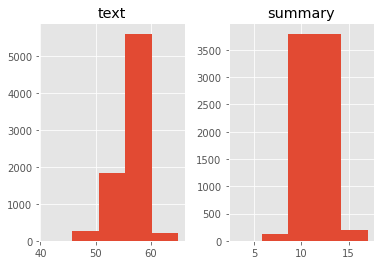

In [26]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [27]:
cnt=0
for i in cleansed_df['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(cleansed_df['cleaned_summary']))

0.9955780164245104


In [83]:
cnt=0
for i in cleansed_df['cleaned_text']:
  if(len(i.split())<=60):
      cnt=cnt+1
print(cnt/len(cleansed_df['cleaned_text']))

0.9733417561591914


In [84]:
max_text_len = 60
max_summary_len = 15

In [87]:
cleaned_text =np.array(cleansed_df['cleaned_text'])
cleaned_summary=np.array(cleansed_df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
cleansed_df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [88]:
cleansed_df

,text,summary
0,the white house on tuesday said that president...,_START_ daman diu revokes mandatory rakshaband...
1,a up board examinee wrote message on her answe...,_START_ malaika slams user who trolled her for...
2,the poster of sridevi and nawazuddin siddiqui ...,_START_ virgin now corrected to unmarried in ...
3,actress priyanka chopra shared video to welcom...,_START_ aaj aapne pakad liya let man dujana be...
4,the indian cricket team new kit was unveiled b...,_START_ hotel staff to get training to spot si...
...,...,...
7665,pakistan has started building nearly 400-kilom...,_START_ un questions india over deportation of...
7666,a crpf jawan was on tuesday axed to death with...,_START_ 5 teenage girls killed in poland escap...
7667,uff yeh the first song from the sonakshi sinh...,_START_ continuously evaluating waivers on ira...
7668,according to reports new version of the 1999 s...,_START_ sl perera slams 13 sixes scores 140 74...


In [94]:
x_train,x_validation,y_train,y_validation=train_test_split(np.array(cleansed_df['text']),np.array(cleansed_df['summary']),test_size=0.1,random_state=0,shuffle=True)

# Rare Word Analysis
Pada Code dibawah ini data akan dieprsiapkan untuk di fit atau di train dalam model menggunakan metode sequence to sequence. Diketahui bahwa proses dari sequence to sequence menggunakan yang namanya Encoder dan Decoder dimana merupakan bagian dari model LSTM, yang dimana nantinya pada output yang diberikan akan ada 2 macam token yang menandakan awalan dan akhiran dari output. pada case ini kami menggunakan token '_START_' dan '_END_'.

Pada proses rare word analysis ini akan dihitung jumlah vocab yang ada pada text dan membandingkannya dengan threshold yang ditentukan. Dan juga akan dicari jumlah common words atau kata kata yang paling sering muncul

In [95]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

In [96]:
threshold=4

count=0
total_count=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    total_count=total_count+1
    tot_freq=tot_freq+value
    if(value<threshold):
        count=count+1
        freq=freq+value
    
print("Percentage of rare words in vocabulary:",(cnt/total_count)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

Percentage of rare words in vocabulary: 29.667282809611827
Total Coverage of rare words: 6.407568833858668


In [97]:
x_tokenizer = Tokenizer(num_words=total_count-count) 
x_tokenizer.fit_on_texts(list(x_train))

x_train_seq    =   x_tokenizer.texts_to_sequences(x_train) 
x_validation_seq   =   x_tokenizer.texts_to_sequences(x_validation)

x_train    =   pad_sequences(x_train_seq,  maxlen=max_text_len, padding='post')
x_validation   =   pad_sequences(x_validation_seq, maxlen=max_text_len, padding='post')

x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 9166


In [98]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

In [100]:
threshold=6

count=0
total_count=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    total_count=total_count+1
    tot_freq=tot_freq+value
    if(value<threshold):
        cnt=cnt+1
        freq=freq+value
    
print("Percantage of rare words in vocabulary:",(cnt/total_count)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

Percantage of rare words in vocabulary: 148.811286249238
Total Coverage of rare words: 20.39396448387934


In [114]:
y_tokenizer = Tokenizer(num_words=total_count-count) 
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_validation_seq   =   y_tokenizer.texts_to_sequences(y_validation) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_validation   =   pad_sequences(y_validation_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

AttributeError: ignored

In [103]:
idx=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        idx.append(i)

y_train=np.delete(y_train,idx, axis=0)
x_train=np.delete(x_train,idx, axis=0)

In [104]:
idx=[]
for i in range(len(y_validation)):
    cnt=0
    for j in y_validation[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        idx.append(i)

y_validation=np.delete(y_validation,idx, axis=0)
x_validation=np.delete(x_validation,idx, axis=0)

# Sequence to Sequence Model

In [107]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

Size of vocabulary from the w2v model = 9166


In [108]:
latent_dim = 300
embedding_dim=200

In [109]:
encoder_inputs = Input(shape=(max_text_len,))

enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 200)      1833200     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 300),    601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [110]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [111]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [116]:
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=15,callbacks=[es],batch_size=128, validation_data=([x_validation,y_validation[:,:-1]], y_validation.reshape(y_validation.shape[0],y_validation.shape[1], 1)[:,1:]))

Epoch 1/15
54/54 [==============================] - 381s 7s/step - loss: 6.0463 - val_loss: 5.1784
Epoch 2/15
54/54 [==============================] - 350s 6s/step - loss: 5.5780 - val_loss: 4.9873
Epoch 3/15
54/54 [==============================] - 345s 6s/step - loss: 5.4397 - val_loss: 4.9795
Epoch 4/15
54/54 [==============================] - 358s 7s/step - loss: 5.3608 - val_loss: 4.9373
Epoch 5/15
54/54 [==============================] - 346s 6s/step - loss: 5.2782 - val_loss: 4.9319
Epoch 6/15
54/54 [==============================] - 389s 7s/step - loss: 5.2113 - val_loss: 4.9087
Epoch 7/15
54/54 [==============================] - 374s 7s/step - loss: 5.1487 - val_loss: 4.9016
Epoch 8/15
54/54 [==============================] - 347s 6s/step - loss: 5.0868 - val_loss: 4.9176
Epoch 9/15
54/54 [==============================] - 347s 6s/step - loss: 5.0251 - val_loss: 4.9169
Epoch 00009: early stopping


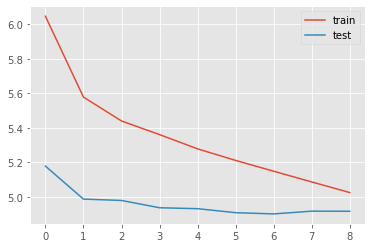

In [117]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Convert the index to word for target and source vocab

In [136]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [138]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [139]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [140]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [142]:
for i in range(0,100):
    print("Review:",seq2text(x_train[i]))
    # print(y_train[i])
    print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(x_train[i].reshape(1,max_text_len)))
    print("\n")

Review: the brother of martyred soldier singh whose body was mutilated by pakistan army has urged the centre to go to war with pakistan if that was the only solution by any chance if the issue can be out with dialogue then even that should be tried he added the slain soldier body was on tuesday 


KeyError: ignored

In [128]:
reverse_target_word_index

{}